In [1]:
from pyspark.sql import SparkSession
    
spark  = SparkSession.builder.master('local[50]').appName('beer_review').getOrCreate()
df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')
df.show()

+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
|       4.0|  5.0|  95213|John Harvards Cri...|  3084|   14.0|   3.0|UPDATED: FEB 19, ...|        2|   33|  6.0|
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|    8.0|   2.0|On tap the Spring...|        3|   33|  4.0|
|       5.0|  8.0|  41336|John Harvards Van...|  3084|   16.0|   4.0|Springfield, PA l...|        5|   58|  7.0|
|       4.0|  5.0|  80424|John Harvards Ame...|  3084|   12.0|   3.0|On tap at the Spr...|      

In [2]:
#Part1
import numpy as np
import matplotlib.pyplot as plt
sc = spark.sparkContext
overall_beer = df.rdd.map(lambda x: (x['beer_name'], x['overall'])).cache()
overall_brewer = df.rdd.map(lambda x: (x['brewer'], x['overall'])).cache()
beer_groups = overall_beer.groupByKey().mapValues(list).collect()
brewer_groups = overall_brewer.groupByKey().mapValues(list).collect()

def calculate_mean(groups):
    mean_ls = []
    for item in groups:
        name = item[0]
        scores = np.array(item[1])
        mean = np.mean(scores)
        mean_ls.append((name, mean))
    return mean_ls

def calculate_std(groups):
    std_ls = []
    for item in groups:
        name = item[0]
        scores = np.array(item[1])
        std = np.std(scores)
        std_ls.append((name, std))
    return std_ls

def calculate_median(groups):
    median_ls = []                    
    for item in groups:
        name = item[0]
        scores = sorted(item[1])
        total = len(scores)
        median = scores[total/2]
        median_ls.append((name, median))
    return median_ls

beer_mean = calculate_mean(beer_groups)
beer_std = calculate_std(beer_groups)
beer_median = calculate_median(beer_groups)

brewer_mean = calculate_mean(brewer_groups)
brewer_std = calculate_std(brewer_groups)
brewer_median = calculate_median(brewer_groups)
                            

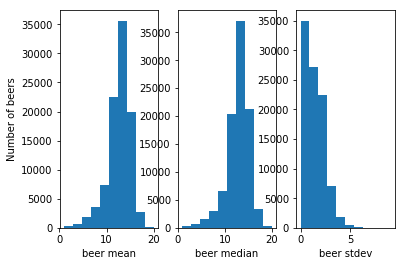

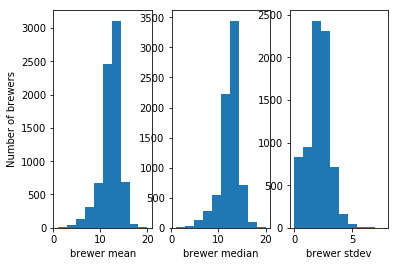

In [3]:
plt.figure(1)
plt.subplot(131)             
plt.hist([x[1] for x in beer_mean])
plt.xlabel('beer mean')
plt.ylabel('Number of beers')
plt.subplot(132)             
plt.hist([x[1] for x in beer_median])
plt.xlabel('beer median')
plt.subplot(133)             
plt.hist([x[1] for x in beer_std])
plt.xlabel('beer stdev')

plt.figure(2)
plt.subplot(131)             
plt.hist([x[1] for x in brewer_mean])
plt.xlabel('brewer mean')
plt.ylabel('Number of brewers')
plt.subplot(132)             
plt.hist([x[1] for x in brewer_median])
plt.xlabel('brewer median')
plt.subplot(133)             
plt.hist([x[1] for x in brewer_std])
plt.xlabel('brewer stdev')

plt.show()

In [5]:
print "I feel people have quite similar tastes, as the standard deviation for most beers are quite low, "
print "and lost of beers have similar mean and median scores"

I feel people have quite similar tastes, as the standard deviation for most beers are quite low, 
and lost of beers have similar mean and median scores


In [6]:
#Part2
import json
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
    vocab = json.load(f)
from scipy.sparse import coo_matrix
TOTAL = df.count()

In [7]:
#Part2
#(a)
import numpy as np
import string
def collect_words(s):
    '''
    Convert the speech to a collection of words
    '''
    s = s.lower().encode('utf-8').translate(string.maketrans("",""), string.punctuation)
    return s.split()
def find_feature(word_ls, vocab_dict):
    index_ls = [0]
    for word in word_ls:
        index = vocab_dict.get(word, -1)
        if index != -1:
            index_ls.append(index+1)
    if index_ls != []:
        col = np.array(index_ls)
        row = np.array([0] * len(index_ls))
        data = np.array([1] * len(index_ls))
        feature = coo_matrix((data, (row, col)), shape=(1, (len(vocab_dict) + 1)))
        return feature
    else:
        return None

In [12]:
#(b)
import math
from pyspark.sql import Row
from math import exp
import numpy as np
proportions = [0.005] * 200

def pos_or_neg(x):
    if x >= 14:
        return 1
    else:
        return 0
    
features = df.rdd.map(lambda x: (x['review_id'], 
                            collect_words(x['review']), x['overall'])).map(lambda x: 
                            Row(feature = find_feature(x[1], vocab), 
                                overall = pos_or_neg(x[2]))).filter(lambda x: x['feature']!= None).cache()
train, val, test = features.randomSplit([0.7, 0.15, 0.15])
mini_batches = train.randomSplit(proportions, seed = 1)

In [8]:


def param_grad(x, y, param):
    pi = 1/(1 + exp( - x.dot(param.T)))
    grad = x.dot(y - pi)
    return grad

def batch_grad(features, param):
    grad_sum = features.map(lambda x: (param_grad(x['feature'], x['overall'], param), 
                                       1)).reduce(lambda x, y: ((x[0] + y[0]), (x[1] + y[1])))
    grad = grad_sum[0]/grad_sum[1]
    return grad      
    
def SGD(batches, c1, c2, regpar, beta):
    for i in range(len(batches)):
        batch = batches[i]
        grad = batch_grad(batch, beta)
        beta = beta + float(c1)/(i+1)**c2 * (grad - regpar)
    return beta

def SGD_plot(df, proportions, c1, c2, regpar, beta):
    batches = df.randomSplit(proportions)
    x_ls = [x for x in range(len(batches)) if x%5 == 0]
    err_ls = []
    like_ls = []
    for i in range(len(batches)):
        batch = batches[i]
        grad = batch_grad(batch, beta)
        beta = beta + float(c1)/(i+1)**c2 * (grad.toarray() - regpar)
        if i%5 == 0:
            error = calc_error(beta, df)
            likelihood = calc_likelihood(beta, df)
            err_ls.append(error)
            like_ls.append(likelihood)
    plt.subplot(121)
    plt.plot(x_ls, err_ls)
    plt.ylabel('error')
    plt.subplot(122)
    plt.ylabel('negative log likelihood')
    plt.plot(x_ls, like_ls)
    plt.show()
    pass
def choose_par(train, val, par_ls, beta):
    err_ls = []
    for par in par_ls:
        mini_batches = train.randomSplit([0.02]*50, seed = 1)
        beta = SGD(mini_batches, 1, 2, 0.1, beta)   
        error = calc_error(beta, val)
        print error
        err_ls.append(error)
    best_par = par_ls[err_ls.index(min(err_ls))]
    return best_par

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot
def if_error(x, param, real):
    predict = 1/(1 + exp(x.dot(param.T)))
    if real == 0:
        if predict > 0.5:
            return 1
        else:
            return 0
    elif real == 1:
        if predict > 0.5:
            return 0
        else:
            return 1

def neg_log(param, x, y):
    likelihood_pi = exp(x.dot(param.T))/(1 + exp(x.dot(param.T)))
    loglike = y*math.log(likelihood_pi) + (1-y)*math.log(1-likelihood_pi)
    return loglike

def calc_error(param, df):
    error = df.map(lambda x: if_error(x[0], param, x[1])).reduce(lambda a, b: a + b)
    error_rate = float(error)/df.count()
    return error_rate

def calc_likelihood(param, df):
    loglike = df.map(lambda x: neg_log(param, x[0], x[1])).reduce(lambda a, b: a + b)
    return loglike


def iterate_sgd(num):
    beta = np.array([0] * len(vocab))
    errval_ls = []
    errtrain_ls = []
    likeval_ls = []
    liketrain_ls = []
    for i in range(num):
        beta = SGD(batches, c1, c2, regpar, beta)
        errval_ls.append(calc_error(beta, val))
        errtrain_ls.append(calc_error(beta, train))
        likeval_ls.append(calc_likelihood(beta, val))
        liketrain_ls.append(calc_likelihood(beta, val))
    return errval_ls, errtrain_ls, likeval_ls, liketrain_ls

0.464021688854
0.463888005091
0.463748973977
0.463393375167
0.4632169126
Training


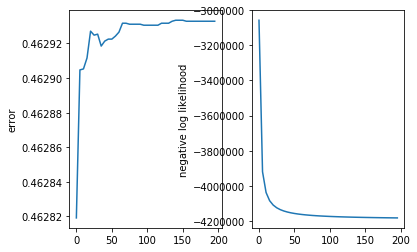

Validation


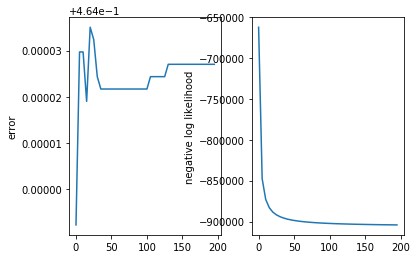

In [9]:
#Part2
par_ls = [0.00001, 0.0001, 0.001, 0.01, 0.1]

best_par = choose_par(train, val, par_ls, np.array([0] * (len(vocab) + 1)))

print "Training"
SGD_plot(train, [0.005] * 200, 1, 2, best_par, np.array([0] * (len(vocab) + 1)))

print "Validation"
SGD_plot(val, [0.005] * 200, 1, 2, best_par, np.array([0] * (len(vocab) + 1)))

In [16]:
#Part3
scores = df.rdd.map(lambda x: Row(feature = np.array([x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']]), 
                               overall = pos_or_neg(x['overall']))).cache()

train_2, val_2, test_2 = scores.randomSplit([0.7, 0.15, 0.15])
proportions = [0.005] * 200
mini_batches_2 = train_2.union(val_2).randomSplit(proportions, seed = 1)

best_par = choose_par(train_2, val_2, par_ls, np.array([0, 0, 0, 0, 0]))

beta = SGD(mini_batches_2, 1, 2, 0.001, np.array([0, 0, 0, 0, 0]))

error_new = calc_error(beta, test_2)

print error_new

0.651915014605


In [22]:
print "The text features are better predictions than scores, as they contain more information"

The text features are better predictions than scores, as they contain more information


In [29]:
#Part4 
import numpy as np
from sklearn import linear_model

df2 = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')
X = df.rdd.map(lambda x: (x['appearance'], x['aroma'], x['palate'], x['style'], x['taste'])).cache()
Y = df.rdd.map(lambda x: pos_or_neg(x['overall'])).cache()

linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0.15,
        learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False)
clf = linear_model.SGDClassifier()
clf.fit(np.asarray(X.collect()), np.asarray(Y.collect()))

prediction_ls = df2.rdd.map(lambda x: (x['review_id'], 
            clf.predict((x['appearance'], x['aroma'], x['palate'], x['style'], x['taste']))[0])).collect()
prediction = dict(prediction_ls)


In [33]:
print prediction_ls[0]


(4, 0)


In [34]:
with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(prediction, f)